# **Importing Session:**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# **Initial process:**

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [ ]:
train_dir =  "/root/.keras/datasets/cats_and_dogs_filtered/train"
validation_dir = "/root/.keras/datasets/cats_and_dogs_filtered/validation"

In [ ]:
train_dir = pathlib.Path(train_dir)
full_train_dataset = tf.data.Dataset.list_files(str(train_dir/'*/*'))

validation_dir = pathlib.Path(validation_dir)
full_validation_dataset = tf.data.Dataset.list_files(str(validation_dir/'*/*'))

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(train_dir/'*/*'))
validation_dataset = tf.data.Dataset.list_files(str(validation_dir/'*/*'))

In [ ]:
# Checking train data is shafelled or not (to avoid Memorizing)
for i in full_train_dataset.take(10):
  print(i)

tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.53.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.289.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.142.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.577.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.620.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.150.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.307.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.316.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.372.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/cats_and_dogs

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])

In [ ]:
CLASS_NAMES

array(['dogs', 'cats'], dtype='<U4')

# **Function to do one hot:**

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

### **Testing our Fanction:**

In [ ]:
get_label("/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.109.jpg").numpy()

array([False,  True])

# **Function to Decode and Cast our images:**

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    # decoding
    image = tf.image.decode_image(image, 3, expand_animations=False)
    # casting (to float32)
    image = tf.cast(image, tf.float32)
    return image

# **Function to Resize images:**

In [ ]:
def resizing_data(image,height, width):
    image = tf.image.resize(image, (height, width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

# **Function to Normalize images:** (between [0,1])

In [ ]:
def normalizing_data(image):
    image /= 255
    return image

# **Function for Agumentation:** (Prevent Overfinting)

In [ ]:
def augmenting_data(image):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.adjust_saturation(image, 0.2)
    image = tf.image.random_hue(image, max_delta=0.5)
    image = tf.image.resize_with_crop_or_pad(image, 180, 180) 
    image = tf.image.random_crop(image, size=[150, 150, 3])  
    return image

# **Function to load images with their labels:**

In [ ]:
def load_image_with_label(image_path):
    label = get_label(image_path)
    image = load_image(image_path)
    return image, label

# **Function to load `train_images`:**

In [ ]:
def load_train_image(image_file):
    image, label = load_image_with_label(image_file)
    image = augmenting_data(image)
    image = normalizing_data(image)
    return image, label

# **Function to load `validatioin_images`:**

In [ ]:
def load_validation_image(image_file):
    image, label = load_image_with_label(image_file)
    image = resizing_data(image, 150, 150)
    image = normalizing_data(image)
    return image, label

# **/////////////////////////////////////////////////////////////////////////////**


In [ ]:
Batch_Size = 64
Shuffle_Size = 10000

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(Shuffle_Size)
train_dataset = train_dataset.batch(Batch_Size)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
validation_dataset = validation_dataset.map(load_validation_image)
validation_dataset = validation_dataset.batch(Batch_Size)
validation_dataset = validation_dataset.cache()

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax'),
])

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
tf.config.optimizer.set_jit(True)

# **---> First Time Itrained The Model:**
### Just declaring function and fit the model with tf data and tensorflow format for coding

## **Each Epoch tooks `15s` in avrage**
## **Each step tooks `175ms` in avrage**
-----------------------------------------------------------------------
### In [08_data_augmentation.ipynb](https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/blob/master/08_data_augmentation.ipynb) Notebook that used DataGenerator:
### **Each Epoch tooks `24s` in avrage**
### **Each step tooks `245ms` in avrage**
----------------------------------------------------------------------

In [ ]:
history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=validation_dataset,)

Epoch 1/100
32/32 [==============================] - 27s 197ms/step - loss: 0.6898 - acc: 0.5210 - val_loss: 0.6812 - val_acc: 0.5550
Epoch 2/100
32/32 [==============================] - 14s 177ms/step - loss: 0.6801 - acc: 0.5620 - val_loss: 0.7161 - val_acc: 0.5030
Epoch 3/100
32/32 [==============================] - 14s 174ms/step - loss: 0.6677 - acc: 0.5925 - val_loss: 0.6802 - val_acc: 0.5850
Epoch 4/100
32/32 [==============================] - 15s 177ms/step - loss: 0.6571 - acc: 0.6170 - val_loss: 0.6782 - val_acc: 0.5840
Epoch 5/100
32/32 [==============================] - 15s 174ms/step - loss: 0.6488 - acc: 0.6240 - val_loss: 0.6759 - val_acc: 0.5940
Epoch 6/100
32/32 [==============================] - 14s 173ms/step - loss: 0.6454 - acc: 0.6375 - val_loss: 0.7084 - val_acc: 0.5560
Epoch 7/100
32/32 [==============================] - 15s 177ms/step - loss: 0.6290 - acc: 0.6560 - val_loss: 0.6498 - val_acc: 0.6120
Epoch 8/100
32/32 [==============================] - 14s 174ms

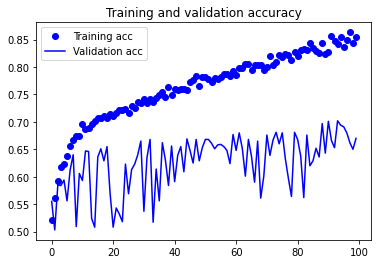

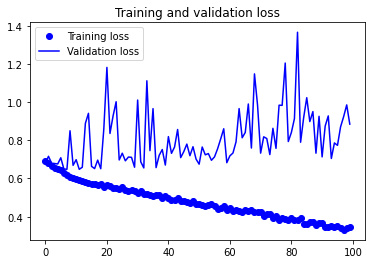

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **---> Second Time trained The Model:**
### This time I used Increase Performance Tools like:
### **Prefetching, Parallelize Transformation and Cache Transformation**
-----------------------------------------
## **Each Epoch tooks `9s` in avrage**
## **Each step tooks `114ms` in avrage**
-----------------------------------------

In [ ]:
history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=validation_dataset)

Epoch 1/100
32/32 [==============================] - 18s 180ms/step - loss: 0.6950 - accuracy: 0.5055 - val_loss: 0.6853 - val_accuracy: 0.5760
Epoch 2/100
32/32 [==============================] - 9s 117ms/step - loss: 0.6852 - accuracy: 0.5580 - val_loss: 0.6990 - val_accuracy: 0.5010
Epoch 3/100
32/32 [==============================] - 9s 114ms/step - loss: 0.6783 - accuracy: 0.5700 - val_loss: 0.7266 - val_accuracy: 0.5040
Epoch 4/100
32/32 [==============================] - 9s 114ms/step - loss: 0.6736 - accuracy: 0.5740 - val_loss: 0.6751 - val_accuracy: 0.5730
Epoch 5/100
32/32 [==============================] - 9s 115ms/step - loss: 0.6670 - accuracy: 0.5970 - val_loss: 0.6889 - val_accuracy: 0.5400
Epoch 6/100
32/32 [==============================] - 9s 115ms/step - loss: 0.6646 - accuracy: 0.5915 - val_loss: 0.6840 - val_accuracy: 0.5700
Epoch 7/100
32/32 [==============================] - 9s 114ms/step - loss: 0.6600 - accuracy: 0.6095 - val_loss: 0.6943 - val_accuracy: 0.548

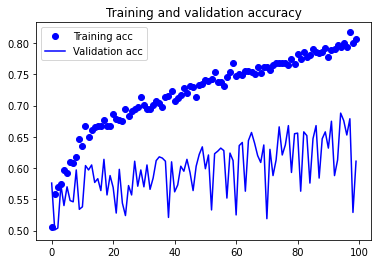

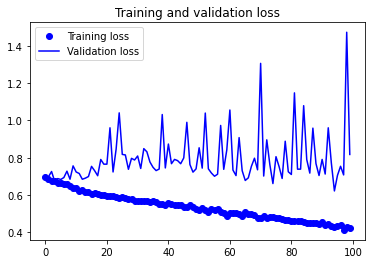

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **---> Third Time trained The Model:**
### This time despite the previous tools I add **XLA** too:
### And also I add 3 more agumentation to prevent overfiting that did not work 
### but we know that it increase the time but we achive:
-----------------------------------------
## **Each Epoch tooks `13s` in avrage**
## **Each step tooks `95ms` in avrage**
-----------------------------------------

In [ ]:
history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=validation_dataset)

Epoch 1/100
32/32 [==============================] - 18s 179ms/step - loss: 0.6990 - accuracy: 0.4970 - val_loss: 0.7668 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 14s 130ms/step - loss: 0.6910 - accuracy: 0.5240 - val_loss: 0.6868 - val_accuracy: 0.5800
Epoch 3/100
32/32 [==============================] - 13s 94ms/step - loss: 0.6863 - accuracy: 0.5395 - val_loss: 0.7207 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 13s 95ms/step - loss: 0.6825 - accuracy: 0.5590 - val_loss: 0.6866 - val_accuracy: 0.5540
Epoch 5/100
32/32 [==============================] - 13s 101ms/step - loss: 0.6788 - accuracy: 0.5615 - val_loss: 0.7109 - val_accuracy: 0.5120
Epoch 6/100
32/32 [==============================] - 14s 96ms/step - loss: 0.6733 - accuracy: 0.5815 - val_loss: 0.6988 - val_accuracy: 0.5130
Epoch 7/100
32/32 [==============================] - 14s 99ms/step - loss: 0.6709 - accuracy: 0.5850 - val_loss: 0.6997 - val_accuracy: 0.5

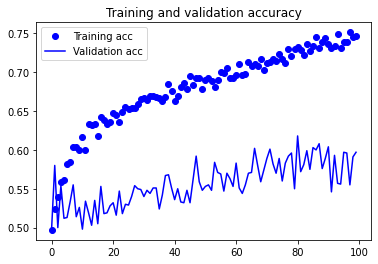

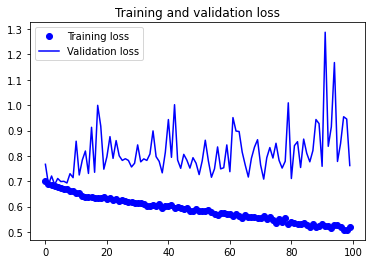

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **توضیحات تکمیلی**
## در این تمرین تلاش شد که تمامی قسمت ها مشابه نوت بوک زیر پیاده سازی شود
## [08_data_augmentation.ipynb](https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/blob/master/08_data_augmentation.ipynb)
## فقط با این تفاوت که از
## **tensorflow** و **tf data**
##  استفاده شود برای افزایش سرعت آموزش مدل که موثر هم بود ولی
## علی رغم اینکه تمامی پیاده سازی ها مطابق نوت بوک شماره 8 صورت گرفت اما 
## مدل به خوبی آموزش نمی بیند (Overfiting)

## حتی اقدام به تغییر پارامتر ها هم صورت گرقت مثل تغییر در پیاده سازی
## **optimizer,mini_bache,layers,shuffle-size,increasing agumentation data,...**
## اما مدل به اندازه ی نوت بوک شماره 8 اموزش نمی بیند

## که شاید یکی از دلایل این اتفاق بیشتر بودن تعداد داده باشد
